# Gaining insight into the Amazon product network
### Applied Data Analysis final project - EPFL (2017)

# Table of contents

1. [Overview](#overview)
2. [Dataset description](#datasetdesc) <br>
    2.1 [Metadata](#dataset_metadata) <br>
    2.2 [Reviews](#dataset_reviews)
3. [Preliminary processing](#prelim_process)
4. [Exploratory data analysis](#exploratory_data) <br>
    4.1 [Missing data statistics](#explo_missing) <br>
    4.2 [Distribution of features](#exploratory_distfeat) <br>
    4.3 [Correlation analysis](#exploratory_corr)
5. [Graph analysis](#graph_analysis)

<a id="overview"></a>
# Overview

Buying from huge e-commerce websites such as Amazon has many advantages, but, paradoxically, users are often confused by the wide variety of products.
They may have a rough idea about the characteristics of the product they want to buy (e.g. a high-end smartphone), and they often undergo the same process of comparing similar products. We want to understand why clients tend to choose a product over another, i.e. what are the desirable characteristics of a popular product? Hopefully, we would get some insights that could prove useful for both clients and vendors.

The Amazon dataset contains relations among products, such as "also viewed", "also bought", "bought together", "bought after viewing". These links can be used to create a graph that represents products with similar characteristics.
Our idea is to exploit the dataset in order to create clusters of competing products. These clusters may be used not only to identify the best product in terms of rating and sales within a group, but also to investigate how brands can influence the sales and the prices of similar products.

The dataset is transformed into a graph of relations between products, where the vertices represent products, and edges represent competition between products. For instance, if some people buy product A after viewing product B and vice versa, and the two products are not bought together, they are competitors. On the other hand, two products that are bought together are not competitors (e.g. a user buys a smartphone and a cover).

This project aims to find recurrent patterns in this graph, and use them for gaining knowledge on how people decide, and on what characteristics make a product desirable over another.

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import json
import seaborn as sns
from IPython.display import IFrame, display
import random
import sys
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import findspark
findspark.init()

import pyspark

conf = pyspark.SparkConf()\
    .setMaster('local[*]')\
    .set('spark.executor.memory', '2g')\
    .set('spark.driver.memory', '2g')\
    .set('spark.executor.instances', '4')
    
sc = pyspark.SparkContext(conf=conf)

<a id="datasetdesc"></a>
## Dataset description

The Amazon dataset consists of two JSON files: 
- *metadata.json*: contains information about the products, such as their unique ID, description and price. The size of the dataset is 9.81 GB (uncompressed, in JSON format).
- *reviews.json*: contains reviews and ratings associated with each product, as well as the helpfulness of each review. The size of the dataset is approximately 87 GB (again, uncompressed and in JSON format).

Since the dataset does not fit in memory, we cannot process it using libraries such as Pandas, unless we reduce its size first.
Therefore, the initial data processing was carried out using **PySpark**, first on the cluster (especially for the reviews dataset) and then in local. While it may seem inappropriate at first, using Spark in local makes sense for medium-sized datasets (like the metadata one), as it automatically parallelizes jobs using all cores, and spills to disk intermediate results that cannot fit in main memory.

<a id="dataset_metadata"></a>
### Metadata
The dataset contains a list of entries of products with the following fields (some of them may be missing):
- **asin**: unique ID of the product.
- **title**: name of the product.
- **price**: price in US dollars.
- **imUrl**: URL of the product image.
- **related**: related products, which contains the sub-lists: *also bought, also viewed, bought together, buy after viewing*.
- **salesRank**: sales rank information, i.e. how well the product compares to other products in the same category in terms of sales.
- **brand**: brand name.
- **categories**: the category(-ies) to which the product belongs.

These fields are already sufficient for building our graph, since they contain the above-mentioned relations between products, as well as their IDs and names. Here we present an example of such a record:

In [12]:
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'price' in x and 'related' in x)\
    .take(1)

[{'asin': '0000143561',
  'categories': [['Movies & TV', 'Movies']],
  'description': '3Pack DVD set - Italian Classics, Parties and Holidays.',
  'imUrl': 'http://g-ecx.images-amazon.com/images/G/01/x-site/icons/no-img-sm._CB192198896_.gif',
  'price': 12.99,
  'related': {'also_viewed': ['B0036FO6SI',
    'B000KL8ODE',
    '000014357X',
    'B0037718RC',
    'B002I5GNVU',
    'B000RBU4BM'],
   'buy_after_viewing': ['B0036FO6SI',
    'B000KL8ODE',
    '000014357X',
    'B0037718RC']},
  'salesRank': {'Movies & TV': 376041},
  'title': 'Everyday Italian (with Giada de Laurentiis), Volume 1 (3 Pack): Italian Classics, Parties, Holidays'}]

Note that we had to use `ast.literal_eval` instead of the JSON library because the dataset is not in standard JSON format. It appears to be in Python's `print() ` format.

Before moving forward, we have to decide whether it makes sense to carry out our analysis on the whole dataset, or if it is more appropriate to select only a subset of all categories. It turns out that the latter is the case: sales in categories such as **Music**, **Books**, or **Clothes** depend on people's personal preferences, and are less (if not at all) prone to competition. On the contrary, electronic products are the ones that are subject to real competition, as clients wants to get the best possible product at the lowest cost. Moreover, this selection step allows us to reduce the size of the dataset and process it more efficiently.

Therefore, the first step consists in listing all categories and selecting those in which we are interested. As can be seen from the example above, categories are represented as hierarchies, e.g. `["Sports & Outdoors", "Other Sports", "Dance"]` means that the product can be found in the category **Sports & Outdoors -> Other Sports -> Dance**. Firstly, we extract the list of macro-categories (top-level categories such as **Sports & Outdoors**) along with their product count, and we inspect them manually. Our goal is to choose macro-categories containing products that can be objectively compared in terms of features and characteristics, such as *Electronics* or *Cell phones*. Converseley, categories of which the purchase decision is subjective (e.g. clothes and books) are discarded.

In [13]:
# Get all top-level categories along with their product count
categories_macro = sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .flatMap(lambda x: x['categories'])\
    .map(lambda x: x[0])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .collect()

In [19]:
# We show the top categories sorted by product count
df = pd.DataFrame(categories_macro)
df.columns = ['category', 'count']
df.sort_values('count', ascending=False).head(30)

,category,count
49,"Clothing, Shoes & Jewelry",3429257
13,Books,2855617
66,CDs & Vinyl,1523001
30,Kindle Store,1088341
72,Sports & Outdoors,543514
73,Electronics,500600
52,Home & Kitchen,437019
32,Cell Phones & Accessories,357693
36,Toys & Games,336460
9,Automotive,331484


According to our considerations, we decided to include the following macro categories in our analysis: **Electronics**, **Cell Phones & Accessories**, **Automotive**, **Tools & Home Improvement**, and **Musical Instruments**. The choice is motivated both by their sizes and by the fact that they represent products that are comparable.

Now, we want to have a more detailed description of the categories. Therefore, for each macro-category, we convert each product's category lists to a tree. We do this in a distributed way, using Spark. The job works as follows:
- **Map phase:** each list is converted to a tree. For instance:

In [883]:
# Transforms a category list into a flat tree (a tree with a linked list topology)
def convert_to_tree(elements):
    root = {}
    node = root
    for element in elements:
        node[element] = (1, {}) # Tuple: (product count, children)
        node = node[element][1]
    return root

In [884]:
convert_to_tree(["Sports & Outdoors", "Other Sports", "Dance"])

{'Sports & Outdoors': (1, {'Other Sports': (1, {'Dance': (1, {})})})}

Each category includes the product count along with its subcategories (children). The product count within a category includes the sum of the product counts of all its children.

- **Reduce phase:** all trees are merged together recursively, creating a huge category tree that reflects the entire dataset.

In [885]:
# Merge nodes
def merge_trees(a, b):
    for key in b:
        if key in a:
            a[key] = (a[key][0] + b[key][0], a[key][1])
            merge_trees(a[key][1], b[key][1])
        else:
            a[key] = b[key]
    return a

In [123]:
# Example
a = convert_to_tree(["Sports & Outdoors", "Other Sports", "Dance"])
b = convert_to_tree(["Sports & Outdoors", "Supplies"])
merge_trees(a, b)

{'Sports & Outdoors': (2,
  {'Other Sports': (1, {'Dance': (1, {})}), 'Supplies': (1, {})})}

Now we run the actual job on Spark.

In [39]:
# Top-level categories of interest
categories_to_extract = set(['Electronics', 'Cell Phones & Accessories', 'Automotive',\
                             'Tools & Home Improvement', 'Musical Instruments'])

# Build the category tree
category_tree = sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .flatMap(lambda x: x['categories'])\
    .filter(lambda x: x[0] in categories_to_extract)\
    .map(convert_to_tree)\
    .reduce(merge_trees)

In the example below, the subtree of *Cell Phones & Accessories* is shown, along with product count for each sub-category. As can be seen, sub categories may differ significantly in terms of belonging products. Therefore, some heuristics may be necessary to group together categories that contains a small number of products.

In [33]:
# Each node represents a (count, children) tuple
category_tree['Cell Phones & Accessories']

(357693,
 {'Accessories': (109763,
   {'Accessory Kits': (26545, {}),
    'Audio Adapters': (497, {}),
    'Batteries': (9882,
     {'Battery Charger Cases': (560, {}),
      'External Battery Packs': (2079, {}),
      'Internal Batteries': (6651, {})}),
    'Bluetooth Speakers': (782, {}),
    'Car Accessories': (5863,
     {'Car Cradles & Mounts': (4705,
       {'Car Cradles': (424, {}), 'Car Mounts': (4189, {})}),
      'Car Kits': (845, {}),
      'Car Speakerphones': (312, {})}),
    'Chargers': (17463,
     {'Car Chargers': (7650, {}),
      'Cell Phone Docks': (1894, {}),
      'International Chargers': (169, {}),
      'Solar Chargers': (284, {}),
      'Travel Chargers': (7122, {})}),
    'Cradles, Mounts & Stands': (48, {'Stands': (47, {})}),
    'Data Cables': (6671, {}),
    'Headsets': (10197,
     {'Bluetooth Headsets': (5066, {}), 'Wired Headsets': (5023, {})}),
    'Phone Charms': (3073, {}),
    'Replacement Parts': (6592, {}),
    'SIM Cards & Tools': (506, {}),
    '

We made an interactive visualization using the 5 macro-categories that we selected. This allowed us to explore the tree and see its overall structure, as the number of sub-categories is too high for being inspected textually. You can see it **[here](https://niccolosacchi.github.io/categories-graph.html)**.

![](imgs/categoryGraph.png)

<a id="dataset_reviews"></a>
### Reviews

The reviews dataset (`reviews.json`) has a size of approximately 87 GB. Each review contains the following fields:
- **reviewerID**: unique ID associated to each user.
- **asin**: unique ID associated to each product.
- **reviewerName**: name of the user.
- **helpful**: helpfulness rating of the review (tuple of 2 elements: "A out of B find this review helpful").
- **reviewText**: text of the review.
- **overall**: rating of the product from 1 to 5 stars.
- **summary** - summary of the review.
- **unixReviewTime** - unix timestamp of the review.
- **reviewTime** - raw timestamp of the review.

Since our project is mainly focused on products, we are not interested in *individual* reviews. However, we still need this dataset in order to compute the aggregate ratings for each product and merge them into our dataset.

<a id="prelim_process"></a>
## Preliminary processing

#### Reduce the Amazon dataset

Due to the large size of the Amazon dataset, we decided to create a custom dataset prior to performing any further analysis. The custom dataset, which has been named *reduced*, contains only products belonging to the macro-categories selected in the previous paragraph. In addition, the review ratings of each product are averaged and merged with the products. As a result, we obtain a smaller *metadata* dataset (1.41 GB) that is enriched with the average product rating field, as well as with the reviews count and their helpfulness.

##### Aggregate ratings
The average product rating is computed from the data in the *reviews* dataset. For each entry, the product ID and the rating are stored, respectively, in the *asin* and *overall* fields. To compute the rating, entries are grouped by product ID and then 
averaged on the *overall* field. In addition to the average rating for each product, we add some extra information which might come handy later: the number of reviews (`num_reviews`), and the ratio of helpful reviews (`helpful_fraction`).
The output is saved in JSON format as `aggregate_ratings.json`. The code for processing the data (shown below) was executed on the ADA cluster.

```python
import json
import pyspark.sql.functions as func
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext()
sqlContext = SQLContext(sc)

rdd = sc.textFile('/datasets/productGraph/complete.json')\
    .map(lambda x: json.loads(x))\
    .map(lambda x: (x['asin'], x['overall'], x['helpful'][0], x['helpful'][1]))

sqlContext.createDataFrame(rdd, ['asin', 'overall', 'helpful_positive', 'helpful_all'])\
    .groupBy('asin')\
    .agg(
        func.mean('overall').alias('average_rating'),
        func.count('overall').alias('num_reviews'),
        (func.sum('helpful_positive') / func.sum('helpful_all')).alias('helpful_fraction')
    )\
    .toJSON()\
    .saveAsTextFile('aggregate_ratings.json')
```

##### Merge the datasets
*Metadata* is filtered so as to mantain only the products belonging to the macro categories of interest, which are then merged with *aggregate_ratings*. The code that generates the *reduced* dataset is shown below. An important observation is that a product can belong to multiple categories (`categories` is a list of lists). However, in our merging process, we need to assign a product to only one category to avoid duplicates. After some investigation, we decided to empirically re-assign products only to the first one in order of appearance, as often the other ones were the result of crawling errors or were inappropriate.

```python
# The list of macro categories that we want to extract
categories_to_extract = set(['Electronics', 'Cell Phones & Accessories', 'Automotive',\
                             'Tools & Home Improvement', 'Musical Instruments'])

# Extract macro category
def extract_category(x):
    x['category'] = x['categories'][0]
    del x['categories']
    x['num_reviews'] = 0 # The number of reviews is 0 in the default case
    if 'salesRank' in x:
        # Convert the dictionary to a more suitable format (tuple)
        if len(x['salesRank']) > 0:
            x['salesRankCat'] = next(iter(x['salesRank'].keys()))
            x['salesRankPos'] = next(iter(x['salesRank'].values()))
        del x['salesRank']
    
    # Change the format of the relations to a simpler one:
    # instead of having nested fields, everything is in the top level.
    # Additionally, missing relations are converted to empty lists,
    # so that they do not need to be checked later.
    x['buy_after_viewing'] = []
    x['bought_together'] = []
    if 'related' in x:
        if 'buy_after_viewing' in x['related']:
            x['buy_after_viewing'] = x['related']['buy_after_viewing']
        if 'bought_together' in x['related']:
            x['bought_together'] = x['related']['bought_together']
        del x['related']
        
    return x

# Load the aggregate ratings
ratings = sc.textFile('data/aggregate_ratings.json')\
    .map(lambda x: json.loads(x))\
    .map(lambda x: (x['asin'], x))

# Filter products and merge datasets.
# Note that we use the left outer join, so as to include products that have no reviews.
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .map(extract_category)\
    .filter(lambda x: x['category'][0] in categories_to_extract)\
    .map(lambda x: (x['asin'], x))\
    .leftOuterJoin(ratings)\
    .map(lambda x: x[1])\
    .map(lambda x: x[0] if x[1] == None else {**x[0], **x[1]})\
    .map(lambda x: json.dumps(x))\
    .saveAsTextFile('data/reduced.json')
```

<a id="exploratory_data"></a>
##  Exploratory data analysis

<a id="explo_missing"></a>
### Missing data statistics
As first thing, we want to see which fields can be missing, and, should they be, the actual fraction of missing values. In order to do this, we sample a subset of the dataset (25%) using Spark, and we process it with Pandas. This will not affect the result considerably, as the sampled dataset is still huge.

In [164]:
df = pd.DataFrame(sc.textFile('data/reduced.json')\
    .sample(fraction=0.25, withReplacement=False, seed=1)\
    .map(lambda x: json.loads(x))\
    .collect())
pd.set_option('display.max_colwidth', 30)
df.head()

,asin,average_rating,bought_together,brand,buy_after_viewing,category,description,helpful_fraction,imUrl,num_reviews,price,salesRankCat,salesRankPos,title
0,B00000JHWT,2.2,[],NaN,[],"[Electronics, Camera & Pho...",Tired of tearing through A...,0.974533,http://ecx.images-amazon.c...,5,NaN,NaN,NaN,Olympus 200-517 NI-MH Batt...
1,B0000223VV,4.8,"[B0000223VQ, B0000223VT]",Forrest,"[B00008WQ2N, B003XREDZA, B...","[Tools & Home Improvement,...",Forrest's blades offer a s...,1.000000,http://ecx.images-amazon.c...,5,118.95,NaN,NaN,Forrest CM08H606100 Chopma...
2,B0000223ZD,5.0,[],NaN,[],"[Tools & Home Improvement,...",For carving and carpenter'...,1.000000,http://ecx.images-amazon.c...,1,20.95,NaN,NaN,Tormek Axe Grinding Jig
3,B00004TZDC,4.0,[],NaN,[],"[Electronics, Portable Aud...",Listen to your favorite MP...,0.580645,http://ecx.images-amazon.c...,11,NaN,NaN,NaN,Sensory Science Rave: MP 2...
4,B00004Y9EN,4.5,[],NaN,[],"[Tools & Home Improvement,...",Designed for frequent use ...,1.000000,http://ecx.images-amazon.c...,2,NaN,NaN,NaN,DELTA 17-784 1/4-Inch Bit Set


asin                 0.000000
average_rating       0.000005
bought_together      0.000000
brand                0.625618
buy_after_viewing    0.000000
category             0.000000
description          0.072262
helpful_fraction     0.504818
imUrl                0.001361
num_reviews          0.000000
price                0.178351
salesRankCat         0.617510
salesRankPos         0.617510
title                0.009485
dtype: float64


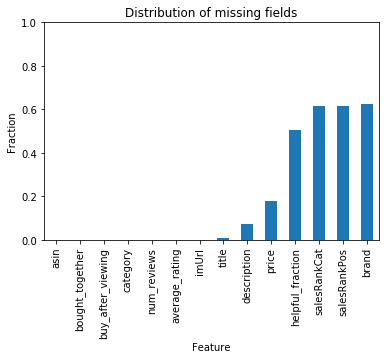

In [165]:
missing_stats = df.isnull().sum()/len(df)
print(missing_stats)
pd.DataFrame(missing_stats).sort_values(0).plot.bar(title="Distribution of missing fields", legend=None)
plt.ylim(0, 1)
plt.ylabel('Fraction')
_ = plt.xlabel('Feature')

The results are mixed:
- The ID (`asin`) and the categories are always present by definition.
- Almost all articles have at least one review (non-null `average_rating`).
- The title can be missing at times, although this is very rare.
- The price and textual description can be missing with a low probability.
- The sales rank and the brand are missing in most cases (about 60% of cases).

<a id="exploratory_distfeat"></a>
### Distributions of features
We now proceed by analyzing the statistics of numeric fields. This might give us some useful insights.

In [166]:
df.describe()

,average_rating,helpful_fraction,num_reviews,price,salesRankPos
count,377663.000000,187013.000000,377665.000000,310308.000000,1.444530e+05
mean,3.947782,0.791446,14.089590,55.504038,4.687263e+05
std,1.150545,0.281049,108.724362,106.199768,5.622865e+05
min,1.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,3.333333,0.680135,1.000000,7.900000,7.561400e+04
50%,4.200000,0.900000,2.000000,17.990000,2.703100e+05
75%,5.000000,1.000000,5.000000,50.600000,6.471730e+05
max,5.000000,1.000000,14495.000000,999.990000,5.270820e+06


From these basic statistics, we can observe that:
- The average ratings tend to be high.
- The distribution of the number of reviews for each article is heavy-tailed (the mean is much higher than the median).
- Most reviews are regarded as helpful (50% of the articles have an helpfulness percentage greater than 90%), meaning that we can take them into account with good confidence.

Additionally, we plot the distribution of the average ratings.

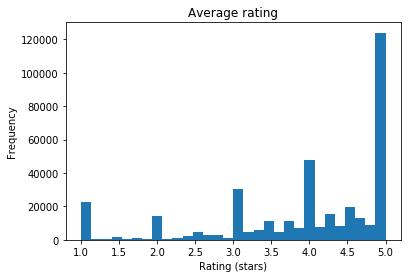

In [10]:
df['average_rating'].plot.hist(title='Average rating', bins=30)
_ = plt.xlabel('Rating (stars)')

As can be seen from the histogram plot above, the ratings are concentrated near integer values. This is due to the fact that most articles contain a small number of reviews (in most cases, only one), and they strongly bias the distribution. Earlier, we observed that the distribution of the *number of reviews* feature is heavy-tailed. To illustrate this clearly, we plot it below.

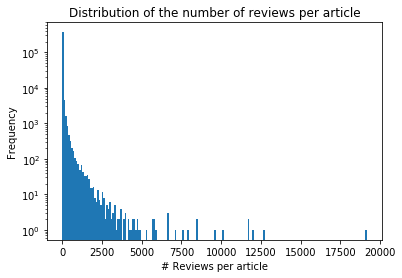

In [11]:
df['num_reviews'].plot.hist(bins=200, log=True, title='Distribution of the number of reviews per article')
_ = plt.xlabel('# Reviews per article')

This indeed confirms our hypothesis. Note that we plotted our histogram in logarithmic scale. The majority of articles contain a very small number of reviews, but there are some outliers that are reviewed a huge number of times.

We plot again the histogram of the average rating per article, but this time we weigh each record according to the number of reviews of the corresponding record.

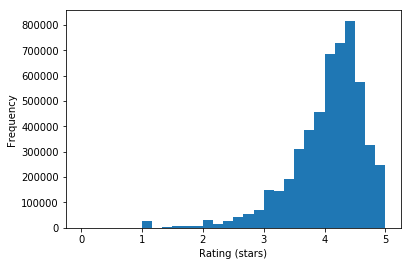

In [167]:
df['average_rating'].fillna(0).plot.hist(weights = df['num_reviews'], bins=30)
_ = plt.xlabel('Rating (stars)')

This result is much smoother and reflects reality. As can be seen, users tend to be very "generous" when reviewing products.

We also plot the distribution of the article prices:

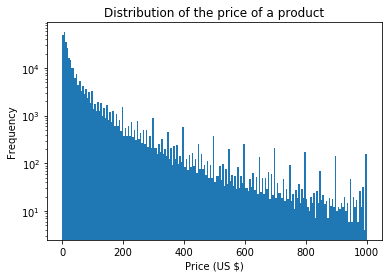

In [13]:
df['price'].plot.hist(bins=200, log=True, title='Distribution of the price of a product')
_ = plt.xlabel('Price (US $)')

Again, we plotted the histogram in log-scale, which reveals that prices are as well distributed according to a heavy-tailed distribution. We can also observe another important detail: the price seems truncated to 1000 dollars (this is also reflected in the summary statistics, which show that the maximum price is 999.99). This seems to be wrong, as the real Amazon website shows products that are well above 1000 dollars as price.
To verify whether this is caused by some error in our analysis, we double-check this fact on the original, full dataset.

In [89]:
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'price' in x and x['price'] > 999.99)\
    .count()

0

Our supposition was correct: the prices are truncated at 999.99 at the source.

<a id="exploratory_corr"></a>
### Correlation analysis
We perform some basic correlation analysis on the sampled dataset, without splitting the categories. Specifically, we investigate the correlations among price, review rating and sales rank, hoping to find some patterns in the distribution of these variables.

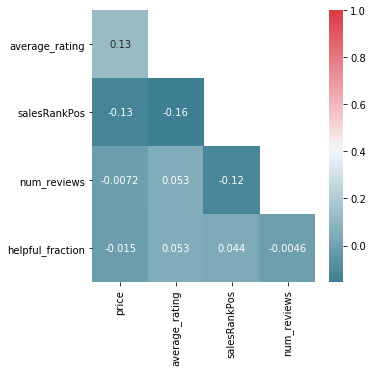

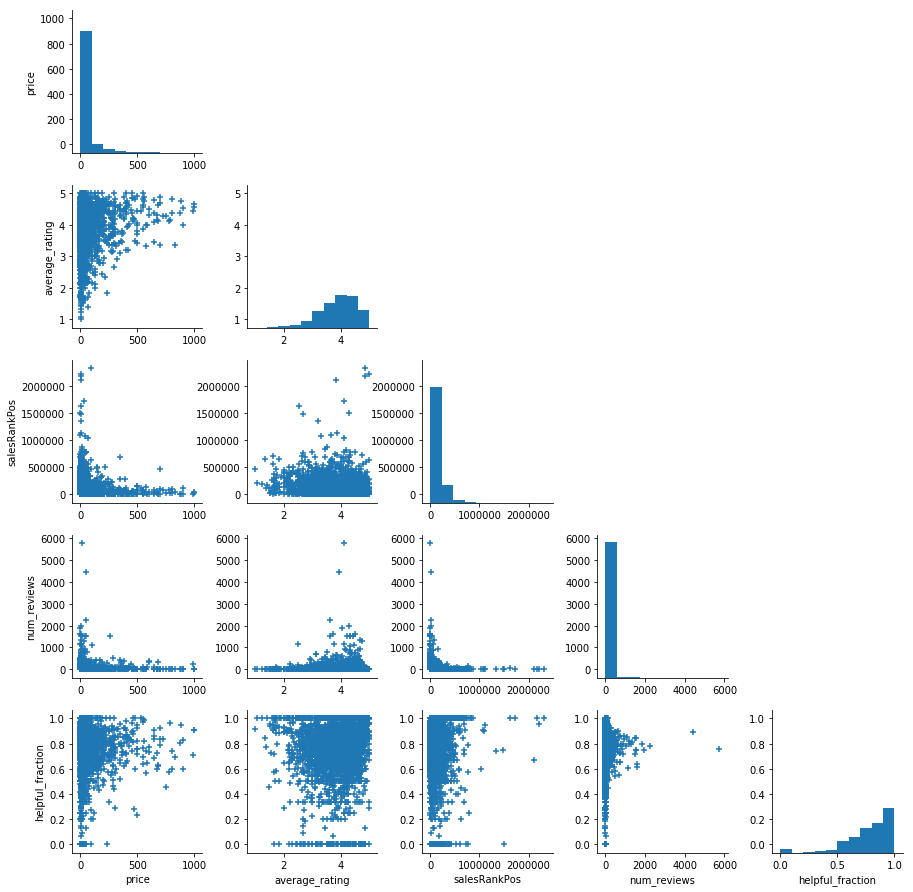

In [7]:
# We select only product with more than 5 reviews in order to have a confident result
df_corr = df[df['num_reviews'] > 5]
df_corr = df_corr[['price', 'average_rating', 'salesRankPos', 'num_reviews', 'helpful_fraction']]\
    .dropna().sample(frac=0.1, random_state=0) # Sub-sample the data

corr = df_corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(5, 5))
sns.heatmap(corr.values[1:,:-1], annot=True, mask=mask[1:,:-1], cmap=cmap,
            xticklabels=corr.columns.values[:-1],
            yticklabels=corr.columns.values[1:])

plot = sns.pairplot(df_corr, markers='+')
for i, j in zip(*np.triu_indices_from(plot.axes, 1)):
    plot.axes[i, j].set_visible(False)

According to the graphs above, we discuss the following outcomes on the correlation analysis:
- The correlation coefficients do not seem to be significant. However, the plots show some trends:
 - As the price increases, the ratings tend to have lower variance and higher mean. In other words, more expensive products have on average higher ratings.
 - As the price increases, the sales rank tends to be low (i.e. good), meaning that costly products are generally sold fast as they may be regarded as superior by people.

Of course, this analysis is superficial, as it is not subdivided by category. Nonetheless, it is interesting because it shows how people tend to think.

<a id="graph_analysis"></a>
## Graph analysis
As we said at the beginning, one of our goals is to analyze competing products and gain useful insights. To corroborate our hypothesis (i.e. cliques represent competing products), we run a pilot analysis on one sample subcategory (*Headphones*)

In our next experiments we will carry out the study on a subset of categories independently. The reason for the subdivision is that:
- It does not make sense to compare products in different categories, although the graph may contain such links (*buy after viewing*). In fact, we expect that such links would be of type *bought together* (e.g. a phone and a cover).
- The algorithms that we are going to use (e.g. max-cliques) are NP-Complete, and will surely benefit from a clever splitting of the data. That said, we observed that the graph is sparse enough to be able to processed in a single pass.

In [168]:
# Collect the products in the "Headphones" category
cat = ['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']
records = sc.textFile('data/reduced.json')\
    .map(json.loads)\
    .filter(lambda x: x['category'][:len(cat)] == cat)\
    .collect()

print(len(records), 'records loaded')

11577 records loaded


Since we need to process big graphs, we decided not to use libraries such as *networkx*. In fact, our early experiments with these libraries turned out to yield unsatisfying performance. As a result, we wrote a small graph library optimized for this kind of sparse, unweighted graphs, and that implements a handful of basic algorithms (max-clique extraction, strongly connected components labeling).

As a first pre-processing step, we build our graph data structure using an efficient layout: adjacency lists indexed by numbers, and not strings. This representation is suitable because the graph is expected to be sparse.

Going into more depth, the graph is constructed as follows:
- We add an edge from product A to product B if clients buy B after viewing A (direct competition).
- We remove an edge between A and B if A and B are frequently bought together (no competition).

In previous experiments, we tried to employ the *also_viewed* relation, with mixed results. This relation produces a graph that is too dense to give meaningful results, which is probably due to the fact that Amazon uses *Collaborative filtering* to produce these recommendations (the details are described [here](https://www.computer.org/csdl/mags/ic/2017/03/mic2017030012.html) and [here](https://docs.aws.amazon.com/AWSECommerceService/latest/DG/RG_CartSimilarities.html)), and not actual graph relations.

In [169]:
from graph import ProductGraph

g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')

In [6]:
g.df.head()

,asin,average_rating,bought_together,brand,buy_after_viewing,category,comp_id_dir,comp_id_undir,comp_size_dir,comp_size_undir,...,fan_diff,fan_in,fan_out,helpful_fraction,imUrl,num_reviews,price,salesRankCat,salesRankPos,title
0,0558835155,3.000000,[],NaN,[],"[Electronics, Accessories & Supplies, Audio & ...",0,0,1,1,...,0,0,0,NaN,http://ecx.images-amazon.com/images/I/21rEirnd...,1,13.95,NaN,NaN,Polaroid Pbm2200 PC / Gaming Stereo Headphones...
1,B00004YJYK,3.166667,[],NaN,[],"[Electronics, Accessories & Supplies, Audio & ...",1,1,1,1,...,0,0,0,0.866667,http://ecx.images-amazon.com/images/I/21DA2HJT...,6,NaN,NaN,NaN,JVC HAG11 Traditional Closed Headphones 30mm D...
2,B0000789GD,3.500000,[],NaN,[],"[Electronics, Accessories & Supplies, Audio & ...",2,2,1,1,...,0,0,0,0.866667,http://g-ecx.images-amazon.com/images/G/01/x-s...,2,NaN,NaN,NaN,Audiobahn Noise-Canceling Headphones (103NC) (...
3,B000CQVX4Y,3.866667,[],NaN,"[B007136B84, B004V4L8PW, B004V4L8RA]","[Electronics, Accessories & Supplies, Audio & ...",3,3,1,7159,...,-3,0,3,0.787879,http://ecx.images-amazon.com/images/I/31qwYVCN...,15,44.30,NaN,NaN,Skullcandy Ti Chick Stereo Headphones - Pink
4,B000J4L7HM,3.000000,[],NaN,"[B0000952XX, B00006JPRQ, B00CM2RYYE, B00004T8R2]","[Electronics, Accessories & Supplies, Audio & ...",4,3,1,7159,...,-2,1,3,1.000000,http://ecx.images-amazon.com/images/I/31RZ%2BN...,2,8.13,NaN,NaN,Incognito Folding Digital Stereo Headphones


In [7]:
g.records[10]

{'asin': 'B00165YVTE',
 'average_rating': 3.4918918918918918,
 'bought_together': [],
 'buy_after_viewing': ['B00CM2RYYE', 'B0094R4Q6Y', 'B0015AHRFK', 'B004U2LC7E'],
 'category': ['Electronics',
  'Accessories & Supplies',
  'Audio & Video Accessories',
  'Headphones'],
 'comp_id_dir': 10,
 'comp_id_undir': 3,
 'comp_size_dir': 1,
 'comp_size_undir': 7159,
 'description': '',
 'fan_diff': -3,
 'fan_in': 1,
 'fan_out': 4,
 'helpful_fraction': 0.8303030303030303,
 'imUrl': 'http://ecx.images-amazon.com/images/I/31w9wENIcFL._SY300_.jpg',
 'num_reviews': 185,
 'price': 13.99,
 'title': 'Sony MDR-AS50G Active Style Spiral Neck-Band Headphones (Silver) (Discontinued by Manufacturer)'}

As can be observed above, our mini-library enriches the dataset with new fields. In particular, we can access it in two ways:
- Through `g.records`, which returns a list of objects.
- Through `g.df`, which returns a pandas `DataFrame`.

The new fields, which are useful for graph analysis, are:
- **fan_in** (also referred to as the in-degree of the node): represents the number of incoming edges on a given node. In our context, it corresponds to the number of other products that lead to the product in exam. As a result, a product with a high fan-in metric is a good one, as people prefer it after viewing many other products.
- **fan_out** (also referred to as the out-degree of the node): represents the number of outgoing edges on a given node. A product with a low fan-in and high fan-out is expected to be worse than other products.
- **fan_diff**: **fan_in** minus **fan_out**.

Furthermore, we extract the strongly connected components of the graph using Kosaraju's algorithm. In this case, we repeat the analysis with two cases: the *directed* case (the graph is kept as-is, with directed edges), and the *undirected* case (the graph is considered as if it were undirected). The latter produces bigger connected components and could be more useful in some cases. The new fields added to the products are:

- **comp_id_dir**: the label of the connected component to which this node belongs (directed graph).
- **comp_size_dir**: the size of the connected component to which this node belongs (directed graph).
- **comp_id_undir**: the label of the connected component to which this node belongs (undirected graph).
- **comp_size_undir**: the size of the connected component to which this node belongs (undirected graph).

Now we analyze the connected components of this subcategory (Headphones):

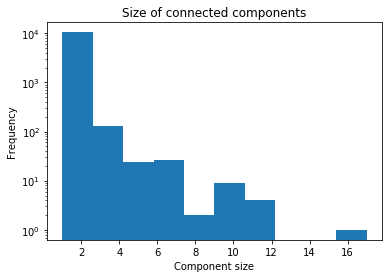

In [170]:
c_df = pd.DataFrame(g.get_connected_components(directed=True))
c_df.columns = ['comp_id']
c_df.groupby(by='comp_id')['comp_id'].count().plot.hist(bins=10, log=True, title='Size of connected components')
_ = plt.xlabel('Component size')

As can be seen from the figure above, the graph is relatively disjoint. There are many components that have no relations among each other, and the average size of a component is small. In particular, we can observe that many components have a size of 1, that is, they are *singletons* (products that have no relations with any other product). We can safely remove those from the graph, as they would only increase the computational cost of processing it.

In [12]:
print('Graph size before pruning:', len(g.records))
g = g.drop_singletons()
print('Graph size after pruning:', len(g.records))

Graph size before pruning: 11577
Graph size after pruning: 7556


### Fan-in/Fan-out analysis
A good indicator of a product success might be represented by its *fan-in* metric, that is, the number of incoming edges. If a product has many incoming edges, it means that people decide to buy it after comparing it with several other products.
Conversely, if a product has a large number of outgoing edges (*fan-out*), it might be an indicator that it is not a good product (or is too pricey). It would also make sense to compare the *fan-in* minus *fan-out* metric, but *not* the ratio (as a product with fan-in 1 and fan-out 0 would get a ratio of infinity).

In [171]:
df = pd.DataFrame()
df['fan_in'] = g.get_fan_in()
df['fan_out'] = g.get_fan_out()
df.index = pd.DataFrame(g.records)['asin']
df.sort_values('fan_in', ascending=False).head()

,fan_in,fan_out
asin,,
B003EM8008,624,2
B001EZYMF4,375,3
B004RKQM8I,273,4
B004PNZFZ8,219,4
B003EM6AOG,183,2


Product **B003EM8008** appears to be a pretty good product, as people buy it after coming from 624 other products.

,fan_in,fan_out
count,11577.000000,11577.000000
mean,1.608793,1.608793
std,9.916964,1.482075
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,2.000000
75%,1.000000,3.000000
max,624.000000,4.000000


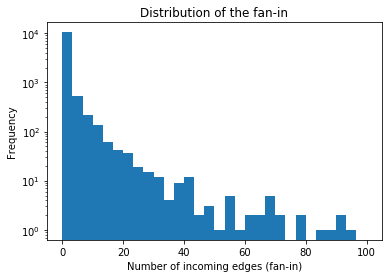

In [172]:
display(df.describe())
df['fan_in'].plot.hist(bins=30,log=True, range=(0, 100), title='Distribution of the fan-in')
_ = plt.xlabel('Number of incoming edges (fan-in)')

Again, as many other statistics in this graph, the fan-in seems to be distributed according to a power law. We can also observe that the maximum value for the fan-out is 4, probably due to display limitations on the website.

### Clique analysis
This is one of the most important aspects of our project. A max-clique is a set of totally interconnected nodes, which, in our scenario, represents products that are in direct competition among each other (and it is not really clear which "wins"). Note that these competition relations might even comprehend products of the same brand: this could turn out to be an interesting tools for vendors.

Our algorithm for finding max-cliques is optimized for dealing with sparse graphs, and works as follows (by induction):
- A single node is always a valid 1-clique
- The current clique is incrementally expanded using a DFS, making sure that the max-clique condition is always satisfied. This is achieved by ensuring that the last inserted node is connected to all previous nodes, and vice versa.
- If the current clique is not a sub-clique of a larger clique, it is marked as a max-clique.

In [15]:
%timeit g.extract_max_cliques()

13 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As can be seen, the performance is very good if we keep the dataset size small by splitting categories.

In [16]:
cliques = g.extract_max_cliques()
print(len(cliques), 'max-cliques found')

7692 max-cliques found


We show some cliques of size 3, and we identify some patterns that are common across categories:

In [17]:
pd.set_option('display.max_colwidth', -1)
g.df.loc[cliques[1088]][['asin', 'title', 'price']]

,asin,title,price
1049,B00AXE96X0,Kidz Gear Wired Headphones For Kids - Orange,19.99
2633,B00AXE9YD2,Kidz Gear Wired Headphones For Kids - Green,21.99
4385,B0096D76QI,Kidz Gear Wired Headphones For Kids - Ltd. Edition White,19.99


One pattern that we observed consists in having the same product (of the same manufacturer), but in different colors. These cliques are widespread, and can easily be detected with some heuristics (e.g. edit distance on the title). Nonetheless, we decided to keep them in our analysis, because they could reveal some useful insights.

In [19]:
g.df.loc[cliques[95]][['asin', 'title', 'price']]

,asin,title,price
89,B0028N78C0,AKG K450 Premium Foldable Headphone,99.95
4399,B004444O4G,"AKG Q460 Mini On Ear Headphones, Quincy Jones Signature Line",89.99
4434,B005LBQ7BY,AKG K 451 High-Performance Foldable Mini Headset,149.95


Another pattern represents different products of the same manufacturer. In this case, people might have a particular brand in mind. Likewise, these cases can be easily detected by looking at the brands of the products in the clique.

In [21]:
g.df.loc[cliques[1153]][['asin', 'title', 'price']]

,asin,title,price
1109,B001EZYMF4,Sennheiser CX 300 II Precision Enhanced Bass Earbuds (Black),30.49
5474,B00C30HUQ2,Symphonized NRG Premium Genuine Wood In-ear Noise-isolating Headphones with Mic (White),25.00
6688,B00HUNUOJW,New Original Gold Xiaomi 2nd Piston Earphone Ii Headphone Headset Earbud with Remote &amp; Mic for Smartphone,23.99


In [22]:
g.df.loc[cliques[1270]][['asin', 'title', 'price']]

,asin,title,price
1221,B007SY4QTW,Plane Quiet Active Noise Canceling Headphone,54.92
1614,B00BSXRBGE,NoiseHush I7 Active Noise-Cancelling Headphones - Retail Packaging - Black/Silver,54.75
4437,B00915OV1E,Solitude XCS Active Noise Canceling and Amplifier Headphones,84.92


Finally, the most interesting clique pattern contains similar products of different manufacturers. In the above examples, we have respectively a set of in-ear headphones, and a set of noise-canceling headphones. Note that the price range appears to be similar.

The result is indeed interesting. We can observe competing products of different brands, a well as competing products of the same brand. In some cases, the cliques represent the same product in different colors.

The important observation, here, is that these products present similar characteristics. Of course, we carried out this analysis on other categories as well (e.g. mobile phones), with similar results.

#### Clique validation
Now that have analyzed some cliques by hand, we want to validate them in a more systematic way. A basic (yet fundamental) test consists in evaluating the categories of the products in cliques and/or connected components. Ideally, if we run our analysis on the whole graph, the products in the same cliques/components should belong to the same category. This also allows us to see if categories are effectively tagged correctly (which should not be taken for granted).

Of course, our final analysis will be carried out on individual subcategories, but it is interesting to see whether the data makes sense.

In [26]:
cat = ['Electronics'] # We select the whole Electronics macro-category
records = sc.textFile('data/reduced.json')\
    .map(json.loads)\
    .filter(lambda x: x['category'][:len(cat)] == cat)\
    .collect()

print(len(records), 'records loaded')

495481 records loaded


In [44]:
g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')
g = g.drop_singletons()
cliques = g.extract_max_cliques()
len(cliques)

308511

In [45]:
# Category verification
count_same = 0
count_all = 0
cl_notsame = []
for c in cliques:
    if len(c) >= 2:
        count_all += 1
        cat = g.df['category'].loc[c[0]]
        same = True
        for elem in c:
            if g.df['category'].loc[elem] != cat:
                same = False
                cl_notsame.append(c)
                break
        count_same += same
print(count_same/count_all, 'of', count_all)

0.695469924249229 of 33399


Almost 70% of products in cliques agree on the category, which is a good result. In particular, we label a clique as a positive match if all the products in the clique belong to the same category. If just one product has a different category than the others, the match is negative.

To see what is happening in the negative cases, we repeat the analysis, but this time on whole connected components. The reason is that we have more surrounding context for comparing products. This time, we relax the condition for a positive match: in a component of 100 elements, for instance, it is very unlikely (if not impossible) that all 100 components belong to the same category. Therefore, we produce a positive match if we can find a *majority* category in a given component (that is, if at least N/2 elements agree on the category). This can be computed in linear time using the Boyer-Moore majority vote algorithm.

In [58]:
# Boyer-Moore majority vote algorithm
def majority(values):
    if len(values) < 2:
        return None
    count = 0
    for v in values:
        if count == 0:
            candidate = v
        if v == candidate:
            count += 1
        else:
            count -= 1
    frequency = 0
    for v in values:
        if v == candidate:
            frequency += 1
    if frequency > len(values)//2:
        return candidate
    else:
        return None

conn_comps = g.extract_connected_components(directed=True)
count_same = 0
count_all = 0
cl_notsame = []
cl_same = []
for c in conn_comps:
    if len(c) > 1:
        cats = g.df['category'].loc[c].values
        maj = majority(cats)
        count_all += 1
        if maj is not None:
            count_same += 1
            cl_same.append(c)
        else:
            cl_notsame.append(c)
print(count_same/count_all, 'of', count_all)

0.7566046798874632 of 14573


The result is similar as before. 75% of strongly connected components have an agreement on the category. Now, we analyze some of the *positive* matches to see what accounts for the small differences. 

In [61]:
g.df.loc[cl_same[1]][['asin', 'title', 'category']]

,asin,title,category
19,B000067SPL,StarTech 10-Feet PS/2 Keyboard / Mouse Extension Cable - M/F (KXT102_10),"[Electronics, Computers & Accessories, Cables & Accessories, Cables & Interconnects, PS/2 Cables]"
40462,B001TKQOTG,Monoprice 6-Feet PS/2 MDIN-6 Male to Male Cable (100092),"[Electronics, Computers & Accessories, Cables & Accessories, Cables & Interconnects, PS/2 Cables]"
49193,B00000J1V7,Belkin PS/2 Keyboard Extension Cable (6 Feet),"[Electronics, Computers & Accessories, Cables & Accessories, Cables & Interconnects, PS/2 Cables]"
60540,B00005118F,C2G / Cables to Go - 02692 - 6ft PS/2 M/M Keyboard Mouse Cable,"[Electronics, Computers & Accessories, Cables & Accessories, Cables & Interconnects, PS/2 Cables]"
101436,B000234JL6,C2G / Cables to Go - 29613 - 6ft Ultima PS/2 M/F Keyboard Extension Cable,"[Electronics, Computers & Accessories, Cables & Accessories, Cables & Interconnects, PS/2 Cables]"
165898,B0000511L1,StarTech.com 6-Feet PS/2 Keyboard or Mouse Cable - M/M (KXT102MM),"[Electronics, Computers & Accessories, Cables & Accessories, Cables & Interconnects, PS/2 Cables]"
205460,B001TKIYTE,Monoprice 100094 10-Feet PS/2 MDIN-6 Male to Male Cable (100094),"[Electronics, Computers & Accessories, Cables & Accessories, Cables & Interconnects, PS/2 Cables]"
233272,B005J1LEZK,PS/2 Mini-Din 6 Pin Male Male Black Cable 6 ft Mouse and Keyboard,"[Electronics, Accessories & Supplies, Audio & Video Accessories, Cables & Interconnects, Video Cables, S-Video Cables]"


In [72]:
g.df.loc[cl_same[9]][['asin', 'title', 'category']]

,asin,title,category
68,B000AQEBGS,Cisco CISCO871W-G-A-K9 871 Ethernet Wireless Router U.S./Americas,"[Electronics, Computers & Accessories, Routers]"
178152,B000A457IQ,Cisco CISCO871-K9 871 Integrated Services Router,"[Electronics, Computers & Accessories, Routers]"
193119,B000A439QS,Cisco CISCO851-K9 851 Router,"[Electronics, Accessories & Supplies, Audio & Video Accessories, Antennas]"
201863,B000A470IQ,Cisco CISCO871-SEC-K9 871 Integrated Services Router,"[Electronics, Computers & Accessories, Routers]"


We can find a lot of these cases where the category of an item has been tagged incorrectly. For example, the Cisco router above should be in the *Routers* subcategory, but it is actually in the *Antennas* category. The problem is not in the dataset, but on Amazon (e.g. [Cisco router product](https://www.amazon.com/dp/B000A439QS)). This method could prove useful for automatically detecting wrong categories and suggesting corrections, dependending on the majority category of the connected component.

We also observed that categories are often mistaken in *Phone Cases* and *Batteries*. Several vendors put phone batteries in the category of phone cases.

By looking at some of the negative matches, we can observe the same result in many components:

In [89]:
g.df.loc[cl_notsame[115]][['asin', 'title', 'category']]

,asin,title,category
3446,B00BJ57JMW,Generic Original OEM Genuine Black Touch Screen Touchscreen Digitizer Glass Panel + Lens Cover Repair Fix Replace Replacement Part For Samsung GT-P5100 P5113 N8000 N8010 N8013 Galaxy Tab 2 10.1,"[Electronics, Computers & Accessories, Laptop & Netbook Computer Accessories, Chargers & Adapters]"
130933,B0098YSL28,New Samsung GT-P7500 7510 Galaxy Tab 10.1 Tablet Touch Screen Digitizer Glass Panel touchpad touchpanel touchscreen replacement repair fix parts,"[Electronics, Computers & Accessories, Laptop & Netbook Computer Accessories, Replacement Screens]"
161519,B00CCXWEZW,Samsung P5113 Galaxy Tab 2 10.1 - New Black Touch Screen Digitizer Touch Display Outer Front Glass Lens Replacement FOR Samsung P5113 p5113 Galaxy Tab 2 10.1 With Free Tools,"[Electronics, Computers & Accessories, Touch Screen Tablet Accessories]"
269320,B00GV3INRW,Ship from USA -- Samsung Galaxy Tab 2 10.1 GT-P5113TS GT-P5113 P5113 P5113TS Touch Screen Digitizer Replacement BLACK,"[Electronics, Computers & Accessories, Touch Screen Tablet Accessories, Cases & Sleeves, Cases]"


In [92]:
g.df.loc[cl_notsame[1]][['asin', 'title', 'category']]

,asin,title,category
21,B000068O3V,Hosa Cable GPR104 1/4 Inch Female TS To RCA Male Adaptor,"[Electronics, Accessories & Supplies, Audio & Video Accessories, Connectors & Adapters]"
98926,B000I98ZNC,Cblwhl 1/4 inch Mono Female / RCA Male Adaptor,"[Electronics, Accessories & Supplies]"
156509,B0018P3DO6,"Monoprice 107242 RCA Plug to 6.35-mm Mono Jack Adaptor, Gold Plated","[Electronics, Accessories & Supplies, Audio & Video Accessories, Connectors & Adapters]"
232885,B000068O5C,"HOSA STEREO 1/4&quot; PHONE (F) - TWO RCA (M) (1-TIP AND 1-RING), 6 in. (Discontinued by Manufacturer)","[Electronics, Accessories & Supplies, Audio & Video Accessories, Cables & Interconnects, Audio Cables, Stereo Jack Cables]"


Indeed, we can conclude that the topology of the graph makes sense. We observed that the latter provides a robust estimate of the similarity between products, both in terms of characteristics and categories. If it is not already doing so, Amazon could benefit from using the graph relations to fix incorrect tags/categories.

Therefore, we can adopt the graph as-is, without doing further clean-ups.

### Devising a metric for preferred products
For the next steps, we need a reliable metric for determining whether a product is *better* than another. By *better*, we mean a product that is preferred over other products, for reasons that are still unknown to us. Obviously, the **buy after viewing** graph relation allow us to observe this directly. However, within a clique, all products are totally interconnected, and it is impossible to determine the "winner" only by looking at the relations.

We argue that the **fan-in** field (the number of incoming edges) is the best indicator for a preferred product. Other possible metrics (along with their disadvantages) would be:
- **Sales Rank:** Amazon provides a ranking for many categories, and the `salesRankPos` represents the position of the product within this ranking. However, this choice presents some disadvantages:
 - The salesRank field is available only on 60% of products.
 - The rank evolves over time. For example, a phone that was very popular 10 years ago (and maybe 1st in the ranking) might be at the end of the ranking today. This will obviously render the data very noisy, and for this reason we need a metric that remains (almost) constant over time.
 - The granularity of categories is too coarse. The ranking is not available for all sub-categories, but only for a couple of them. Many products in the *Electronics* sub-categories refer to the *Electronics* macro-category.
- **Average rating:** we believe that this is the worst choice. As observed earlier, people tend to give very high and similar ratings on average, and comparing them tends to produce noisy results.
- **Number of reviews:** expectedly, the number of reviews linearly correlates with the number of sales (if we assume that a constant fraction of people review a product). This value could be used for estimating the total number of sales of a product, and thus, its popularity. However, it does not directly indicate whether a product is preferred over another.

Our choice for the **fan-in** is motivated by the fact that it represents the number of times a given product has been preferred over other products, which is different from saying that it sold more or is more popular. Of course, these quantities are related in some way (as we will see in a moment), but they also present fundamental differences.

Now we present a correlation analysis on the cliques. Specifically, we convert the numeric indicators of a product (fan-in, average rating, sales rank, number of reviews, and price) to a rank within the clique, and we evaluate the Pearson correlation coefficients between these variables. Using the rank instead of the absolute value provides a more fair comparison.

In [96]:
cat = ['Electronics'] # We select the whole Electronics macro-category
records = sc.textFile('data/reduced.json')\
    .map(json.loads)\
    .filter(lambda x: 'salesRankPos' in x and 'price' in x and 'average_rating' in x)\
    .filter(lambda x: x['category'][:len(cat)] == cat)\
    .collect()
print(len(records), 'records loaded')

78484 records loaded


In [98]:
g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')
g = g.drop_singletons()
cliques = g.extract_max_cliques()
len(cliques)

46171

In [161]:
count = 0
count_tot = 0
cols = ['average_rating', 'price', 'salesRankPos', 'fan_in', 'num_reviews']
data = []
for c in cliques:
    if len(c) >= 2:
        df_tmp = g.df[cols].loc[c].rank()
        data.append(df_tmp)
res = pd.concat(data)
print('Sample ranks from the data')
res.head()

Sample ranks from the data


,average_rating,price,salesRankPos,fan_in,num_reviews
1,2.0,1.0,1.0,2.0,2.0
1083,1.0,2.0,2.0,1.0,1.0
6,1.0,2.0,1.0,2.0,2.0
4091,2.0,1.0,2.0,1.0,1.0
18,1.0,2.0,1.0,1.5,1.0


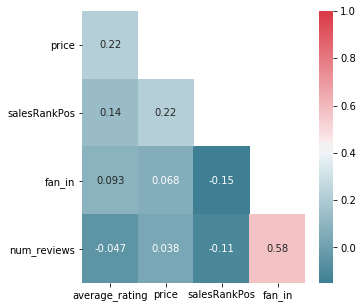

In [103]:
corr = res.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(5, 5))
_ = sns.heatmap(corr.values[1:,:-1], annot=True, mask=mask[1:,:-1], cmap=cmap,
            xticklabels=corr.columns.values[:-1],
            yticklabels=corr.columns.values[1:])

The correlation analysis reveals some interesting (and expected) correlations in cliques. The fan-in has a moderate correlation with the number of reviews, and a weak correlation with the sales rank. We can also observe a weak correlation between the sales rank and the price, which makes us suppose that people tend to prefer cheaper products (note that a lower sales rank is better).

To give more support to our argument, we now focus on the rest of the graph (not cliques). In the general case, we want to see if the fan-in can reliably predict the direction of an edge between two products, that is, if we have two products A and B, and $A_{fan\_in} > B_{fan\_in}$, then there is a directed edge from B to A. If this is true, then we can generalize this principle to cliques, where we do not have the ground truth.

In [104]:
# We make sure to explicitly avoid cliques
relations = []
for i, a in enumerate(g.records):
    for b_ in a['buy_after_viewing']:
        if b_ not in g.name_id_mapping:
            continue
        j = g.name_id_mapping[b_]
        b = g.records[j]
        if a['asin'] not in b['buy_after_viewing']:
            relations.append([i, j]) # First: worst - second: best

In [109]:
positive_matches = 0
all_matches = 0
for c in relations:
    if g.df['fan_in'].loc[c[1]] > g.df['fan_in'].loc[c[0]]:
        positive_matches += 1
    all_matches += 1
print(positive_matches/all_matches, 'out of', all_matches, 'relations')

0.9668089585404362 out of 85505 relations


In 96% of cases, the edges point toward the product with the highest fan-in, which reinforces our argument. From now on, we will use fan-in as a metric for evaluating products, especially in cliques.

## Feature and text analysis

Given two related products (e.g. the products in a cliques or just connected by one edge), we want to predict the preferred one (i.e. the one with the highest fan-in) by analyzing their features (both numeric and textual). Our goal is not to build a predictor, but to analyze what the model learns (interpretation) and gain some insight on how people decide.

For this analysis, we focus on the *Cell Phones* subcategory, which is a field with strong competition. We do this analysis on **buy after viewing** relations, and not cliques.

Our interpretation pipeline aims at comparing two products (specifically, *ranking* them). Given the features of two products, we want to feed them to a binary classifier that determines the best of the two. This approach, in the [learning to rank](https://en.wikipedia.org/wiki/Learning_to_rank) context, is referred to as the **pairwise approach**. A good reference for these models can be found [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.222.6261&rep=rep1&type=pdf).

### Text analysis
The text analysis pipeline works as follows:
- Given two products, we extract their textual features from their *titles* using a tf-idf vectorizer. We also tried the description, with similar results. The title represents a more direct description of the product and is easier to interpret.
- We subtract the feature vectors of the two products to produce the feature vector to supply to the classifier. As for the ground truth, provided that the subtraction is $A - B$, we put the label 0 if the winner is A, and 1 if the winner is B. For each sample, we also provide the opposite sample ($B - A$ with the inverted label), so that the classifier learns the commutative property and the classes are perfectly balanced.
- We train a random forest on our data, with a fixed number of estimators (1000) and an optimal tree depth which is determined by grid search and cross-validation. Specifically, we perform a 5-fold cross-validation and select the depth that yields the best accuracy on the validation set.
- We evaluate our model on a small test set (20% of the data) to determine whether it overfitted or not.
- We take the most important features learned by the random forest (given by the sorted `clf.feature_importances_`), and we try to interpret them. However, this is not sufficient, as we get only an indication of their magnitude (a positive value), and not whether they affect positively or negatively the result.
- To get an idea of their impact, we select the top 1000 features (i.e. words) in terms of importance, and we use them to train a L2-regularized logistic regressor. By analyzing the weights learned by the latter, we can observe the sign of each feature, which corresponds to the impact (negative or positive) of the feature on the result.

While this process might seem convoluted, it is the result of many experiments. Initially, we tried to use L1-regularized logistic regression instead of random forests, which is expected to select only a few features (thanks to its sparsity property). Indeed, out of the thousands of features, only a few of them are selected. However, the model tends to overfit some features (e.g. the name of the model of a particular product, such as GT-I9500) in order to maximize the score, and these features are given a huge weight. As a result, it becomes impossible to interpret the model, as the useful features are buried by outliers.

On the other hand, random forests average the results of many weaks predictors, and are less susceptible to this kind of overfitting. Therefore, our idea is to use random forests to perform feature selection, and interpret the useful features using logistic regression.

In [179]:
cat = ['Cell Phones & Accessories', 'Cell Phones']
records = sc.textFile('data/reduced.json')\
    .map(json.loads)\
    .filter(lambda x: 'title' in x and len(x['title']) > 0 and 'price' in x and 'average_rating' in x)\
    .filter(lambda x: x['category'][:len(cat)] == cat)\
    .collect()
len(records)

5554

In [180]:
g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')
g = g.drop_singletons()

In [181]:
# Extract non-clique relations
relations = []
for i, a in enumerate(g.records):
    for b_ in a['buy_after_viewing']:
        if b_ not in g.name_id_mapping:
            continue
        j = g.name_id_mapping[b_]
        b = g.records[j]
        if a['asin'] not in b['buy_after_viewing']:
            relations.append([i, j])

Since the graph contains relations between products, our samples are correlated. This means that the same product may have relations with multiple other products, and as such, the same product will be present in multiple training samples. We must avoid this, as it would bias our cross-validation results. Ideally, we should make sure that the products sets in the cross-validation buckets are disjoint, that is, a certain product appears only in *one* bucket. One way to ensure this is to remove all products that have already been seen before, thereby guaranteeing their uniqueness.

In [182]:
# Decorrelation
def decorrelate(relation_list):
    node_set = set()
    result = []
    for c in relation_list:
        ok = True
        for node in c:
            if node in node_set:
                ok = False
                break
        if ok:
            for node in c:
                node_set.add(node)
            result.append(c)
    return result

In [183]:
relations = decorrelate(relations)
len(relations)

1427

In [184]:
pairs = []
for c in relations:
    if len(c) >= 2:
        pairs.append(c)
pairs = np.array(pairs)
len(pairs)

1427

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import itertools
import multiprocessing

num_estimators = 1000
num_threads = multiprocessing.cpu_count()
print('Random forests will be trained using', num_threads, 'CPU cores and', num_estimators, 'estimators')

Random forests will be trained using 4 CPU cores and 1000 estimators


In [147]:
# Train a model (and validate it) using Random Forests
def train_model_rf(X_tr, y_tr, X_va, y_va, depth):
    clf = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=num_estimators, n_jobs=num_threads)
    clf.fit(X_tr, y_tr)
    va_score = clf.score(X_va, y_va)
    return va_score, clf

# Train a model (and validate it) using L2-penalized logistic regression
def train_model_lr(X_tr, y_tr, X_va, y_va, lambda_):
    clf = LogisticRegression(penalty='l2', C=lambda_, fit_intercept=False)
    clf.fit(X_tr, y_tr)
    va_score = clf.score(X_va, y_va)
    return va_score, clf

In [148]:
from scipy.sparse import hstack, vstack, csr_matrix
from sklearn.model_selection import KFold, train_test_split

def get_features(relation_list):
    result = set()
    for c in relation_list:
        for elem in c:
            result.add(elem)
    
    return g.df['title'].loc[list(result)]

def build_data(relation_list):
    X = []
    y = []
    for c in relation_list:
        if len(c) >= 2:
            # We use permutations instead of combinations because we also want elements in reversed order
            for pair in itertools.permutations(c, 2):
                pair = list(pair)
                a = g.df['fan_in'].loc[pair[0]]
                b = g.df['fan_in'].loc[pair[1]]
                if a == b:
                    continue # Discard ties
                x_this = features[pair[0]] - features[pair[1]]
                y_this = 0 if a > b else 1
                X.append(x_this)
                y.append(y_this)
    return vstack(X), y

data_cv, data_test = train_test_split(pairs, test_size=0.2, random_state=0, shuffle=True)

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
depths = np.arange(5, 30, 5)
all_accuracies = []
try:
    for depth in depths:
        accuracies = []
        for train, validation in k_fold.split(data_cv):
            vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w[a-zA-Z0-9_-]+\\b')
            vectorizer.fit(get_features(data_cv[train]))
            features = vectorizer.transform(g.df['title'])
            X_tr, y_tr = build_data(data_cv[train])
            X_va, y_va = build_data(data_cv[validation])
            va_score = train_model_rf(X_tr, y_tr, X_va, y_va, depth)[0]
            accuracies.append(va_score)
        print('Depth:', depth, '- Accuracy:', np.mean(accuracies), '- std:', np.std(accuracies))
        all_accuracies.append(np.mean(accuracies))
except KeyboardInterrupt:
    print('Interrupted.')

best_depth = depths[np.argmax(all_accuracies)]
print('Best depth:', best_depth)

Depth: 5 - Accuracy: 0.595071547226 - std: 0.0398799800378
Depth: 10 - Accuracy: 0.600384531886 - std: 0.0274005121685
Depth: 15 - Accuracy: 0.594992816457 - std: 0.0318879724426
Depth: 20 - Accuracy: 0.606192750951 - std: 0.034143930151
Depth: 25 - Accuracy: 0.599872247678 - std: 0.0279655370407
Best depth: 20


In [149]:
# Perform evaluation on the test set
vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w[a-zA-Z0-9_-]+\\b')
vectorizer.fit(get_features(data_cv))
features = vectorizer.transform(g.df['title'])
X, y = build_data(data_cv)
X_te, y_te = build_data(data_test)
score, clf = train_model_rf(X, y, X_te, y_te, best_depth)
print('Test accuracy:', score)

Test accuracy: 0.58896797153


We get 58% of accuracy on the test set, which is not impressive. However, it is worth noting that the classes are perfectly balanced, and therefore the result is better than random. We can surely find some insights in the textual features.

In [150]:
important_features = pd.DataFrame(clf.feature_importances_, columns=['importance'])
important_features['std'] = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

important_features = important_features.sort_values(by='importance', ascending=False).head(1000)

mapping = np.array(vectorizer.get_feature_names())
num_index = important_features.index
important_features.index = important_features.index.map(lambda x: mapping[x])
important_features.head(20)

,importance,std
unlocked,0.028817,0.028300
black,0.027031,0.028810
android,0.019951,0.021543
and,0.018147,0.021599
phone,0.016169,0.015810
with,0.014900,0.016898
camera,0.014252,0.016952
gsm,0.013122,0.014085
cell,0.011640,0.013552
gps,0.011589,0.015720


Some results are already starting to dealineate, but before reaching a conclusion, we move forward to the next part of the interpretation and report our findings in the end.

We now select the top 1000 features and use them for training a logistic regression model.

In [151]:
X, y = build_data(data_cv)
X_te, y_te = build_data(data_test)
X = X.tocsr()[:, num_index.values]
X_te = X_te.tocsr()[:, num_index.values]
score, clf = train_model_lr(X, y, X_te, y_te, 1e1)
print('Test accuracy:', score)

Test accuracy: 0.576512455516


The test accuracy is similar as with random forests, and we are sure that the classifier will not have overfitted certain features. We now show the weights corresponding the same features that we reported in the table above.

In [153]:
important_features_lr = pd.DataFrame(-clf.coef_[0], columns=['importance'])
important_features_lr.index = important_features_lr.index.map(lambda x: important_features.index[x])
important_features_lr.head(25)

,importance
unlocked,7.618841
black,5.478621
android,2.683909
and,1.923340
phone,1.242116
with,1.665849
camera,1.029032
gsm,1.931016
cell,-2.246584
gps,1.381554


Intuitively, we have reported the weights in a way that positive values are "good" (i.e. correlate with the best product) and negative values are "bad".

We can observe some patterns:
- Putting the color of the product on the title (e.g. black or white, but not pink) has a beneficial effect. Clients probably are reassured by the fact that the product matches the color that they want (and this might not always be consistent with the photo).
- Words that indicate the presence of a feature (e.g. with, gps, camera, unlocked, prepaid, bluetooth) also have a beneficial effect.
- The most striking result, not unexpected, is that brand names also appear in this list (Apple, Samsung, iPhone, Galaxy).

The best way to verify whether these weights are correct is to check some of these relations by hand. We query the graph by looking at the keywords in the title: if, in a relation A -> B, product A contains the keyword, we decrement a counter by 1. If product B contains the keyword, we increment the counter by 1 (cross-relations are automatically balanced). Eventually, we end up with a "balance" that describes whether people tend to escape from a product or choose it.

In [208]:
def get_balance(keyword):
    num = 0
    for i, a in enumerate(g.records):
        for b_ in a['buy_after_viewing']:
            if b_ not in g.name_id_mapping:
                continue
            j = g.name_id_mapping[b_]
            b = g.records[j]
            if a['asin'] not in b['buy_after_viewing']:
                if keyword in g.records[i]['title']: # Worst product
                    num -= 1
                if keyword in g.records[j]['title']: # Best product
                    num += 1
    print('The balance for "'+keyword+'" is:', num)

In [217]:
get_balance('Samsung')
get_balance('Apple')
get_balance('iPhone')
get_balance('Black')
get_balance('Android')
get_balance('Pink')
get_balance('Unlocked')

The balance for "Samsung" is: -52
The balance for "Apple" is: 45
The balance for "iPhone" is: 66
The balance for "Black" is: 753
The balance for "Android" is: 297
The balance for "Pink" is: -234
The balance for "Unlocked" is: 1208


These results clearly reflect those on the table. Surprisingly, Samsung is negative, but it is worth noting that the dataset is from a few years ago, and it reflects the entire history of Amazon (and not only the recent market).
Out of the non-brand words, "Black" and "Unlocked" have the highest impact.

## Numeric feature analysis
It would be interesting to repeat the same experiment using only some numeric features (e.g. price, rating, and number of reviews).

In [156]:
features = csr_matrix(g.df[['num_reviews', 'average_rating']].values)
X, y = build_data(data_cv)
X_te, y_te = build_data(data_test)
score, clf = train_model_rf(X, y, X_te, y_te, 10)
print('Test accuracy:', score)

Test accuracy: 0.843416370107


Since we have only 2 features, it is almost impossible to overfit here, so we used a fixed tree depth of 10.
The result is impressive, it looks like these features alone can predict many relations.

In [157]:
clf.feature_importances_

array([ 0.80161457,  0.19838543])

The number of reviews has the highest impact.
To see what the model is learning, we plot its decision boundaries.

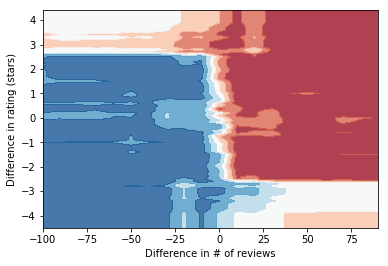

In [174]:
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
x_min = -100
x_max = 100
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),
                     np.arange(y_min, y_max, 0.1))

Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=.8)
plt.xlabel('Difference in # of reviews')
_ = plt.ylabel('Difference in rating (stars)')

The result is surprising and unsurprising at the same time: people tend to choose a product according to the number of reviews, and the role of the actual rating is marginal (unless there is a big discrepancy between the ratings of the two products). This may be caused by the fact that ratings tend to concentrate on 4-5 stars.

# Conclusion
During the development of this project we exposed the relations between the product so as to detect the comparable ones in a novel way. By using these relations, we discovered some non-trivial patterns that people follow when presented with different choices. In particular, we found out some of the features that affect the user in the choice of a product, e.g. some specific keywords in the title (e.g. colors), number of reviews, and, most importantly, brand names. We also proposed a suitable metric for comparing products (the fan-in of a node) in particular cases, such as inside cliques.

With regard to our research questions:
- Is our assumption founded? (Do clusters effectively represent competing products?)
 - Yes, we have checked some of them by hand, and they indeed represents product with very similar characteristics. Moreover, we ran some consistency tests that were successful.
- Given some products with similar characteristics and use cases (e.g. a GPU for mining), can we find the best one? For instance, a suitable metric would be the rank of a product within a cluster.
 - We found out that the most appropriate metric for ranking a product within a cluster (whether a connected component or a clique) is the fan-in of the node. By analyzing the text in the titles, we can weakly predict the preferred product in a pair of competing products. Despite the accuracy being only slightly better than random, we detected some keywords that correlate with the best product, and these could provide useful suggestions for vendors. Additionally, we observed that users tend to buy products that have many reviews, and give less weight to the average rating (which presents a skewed distribution).
- Are product choices affected by brand names?
 - Brand names indeed influence people's choices. However, we cannot know whether this is due to popularity and advertising reasons, or due to the fact that famous brands have better resources and manufacture products that are superior. Both of them might be partially true. As for the price, we did not find any evidence that suggests that 
- Could this project prove useful for users who want both to choose wisely and save time?  The same applies for vendors, who could see how their products relate to competitors' products.
 - We believe that our project reveals some useful insights, especially for vendors.